# Análisis de series temporales del viento en el Caribe basado en NCEP-DOE Reanalysis-2

## Fuente de datos y descripción

Los datos de viento utilizados en este análisis se basan en el **NCEP/DOE Reanalysis-2 (R2)** del NOAA de Estados Unidos.

- Página oficial de información:  
  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html

NCEP-Reanalysis2 es un conjunto de datos de reanálisis climático que combina observaciones atmosféricas globales con un modelo numérico para reconstruir el estado de la atmósfera desde 1979 hasta la actualidad.  
Proporciona diversas variables atmosféricas —como viento (u/v-wind), temperatura, humedad y altura geopotencial— en forma de **series temporales con intervalos de 6 horas**.

En este análisis se utiliza el método de acceso remoto **OPeNDAP**, lo cual permite cargar campos globales de viento para horas, niveles y regiones específicas **sin necesidad de descargar archivos de gran tamaño al sistema local**.

El flujo de trabajo para procesar y visualizar datos NetCDF se basó en el ejemplo del proyecto **leafmap** (https://leafmap.org/notebooks/52_netcdf/), adaptándolo para analizar la variabilidad espacio-temporal del viento en la región del Caribe.

In [1]:
# !pip install -U -q leafmap
# !pip install -U -q xarray rioxarray netcdf4 localtileserver

In [1]:
import leafmap
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

## Verificación del rango temporal de los datos NCEP/DOE Reanalysis-2

En este paso se cargan directamente, mediante **OPeNDAP**, los datos del viento u (uwnd) del año 2025 del **NCEP/DOE Reanalysis-2 (R2)** proporcionados por NOAA PSL, y se verifica el rango temporal incluido en el archivo NetCDF.

La variable `uwnd` (u-wind) representa el componente zonal del viento, es decir, la componente horizontal en dirección este–oeste.
- **u (viento zonal, zonal wind)** → componente este–oeste (positivo hacia el este / negativo hacia el oeste)  
- **v (viento meridional, meridional wind)** → componente norte–sur (positivo hacia el norte / negativo hacia el sur)

Dado que los datos de reanálisis están estructurados como series temporales con un intervalo de 6 horas, es fundamental verificar de antemano si la fecha y hora que se desean analizar realmente existen en el conjunto de datos.  
Esto permite evitar errores derivados de fechas inexistentes.

Al ejecutar el siguiente código, se mostrarán **el inicio** y **el fin** del rango temporal disponible en el archivo correspondiente al año seleccionado.

In [2]:
# Datos de viento u (u-wind) del NCEP/DOE Reanalysis-2 para el año 2025 (OPeNDAP)
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/uwnd.2025.nc"
ds = xr.open_dataset(url)

# Verificar el rango temporal
print("Inicio de los datos:", str(ds.time.min().values))
print("Fin de los datos:", str(ds.time.max().values))

Inicio de los datos: 2025-01-01T00:00:00.000000000
Fin de los datos: 2025-09-30T18:00:00.000000000


## Función para extraer campos de viento del NCEP/DOE Reanalysis-2

La función `make_ncep_r2_wind()` descarga, mediante acceso **OPeNDAP**, los valores de **u-wind (uwnd)** y **v-wind (vwnd)** del **NCEP/DOE Reanalysis-2 (R2)** correspondientes a un **nivel de presión (pressure level)** y a una **fecha y hora específicas (`target_time`)**.  
Posteriormente, guarda el campo global de viento en un archivo NetCDF.

### Niveles de presión disponibles (17 niveles en hPa)

Los niveles basados en presión incluyen los siguientes 17 valores:

`1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10`

Al proporcionar uno de estos valores en el parámetro `level_hpa`, la función seleccionará el nivel de presión más cercano disponible en los datos.

In [3]:
def make_ncep_r2_wind(target_time, level_hpa, out_file):
    """
    Carga los campos globales de viento u/v del NCEP/DOE Reanalysis-2
    para una fecha y un nivel de presión específicos,
    y los guarda en un archivo NetCDF (u_wind, v_wind).
    """

    # Procesar target_time
    if isinstance(target_time, str):
        t = datetime.fromisoformat(target_time)
    else:
        t = target_time
    year = t.year

    # URL OPeNDAP
    url_u = f"https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/uwnd.{year}.nc"
    url_v = f"https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/vwnd.{year}.nc"

    print("URL de U-wind:", url_u)
    print("URL de V-wind:", url_v)

    # Abrir datos remotos
    ds_u = xr.open_dataset(url_u)
    ds_v = xr.open_dataset(url_v)

    # Seleccionar el nivel y el tiempo más cercanos
    u_sel = (
        ds_u["uwnd"]
        .sel(level=level_hpa, method="nearest")
        .sel(time=[t], method="nearest")
    )
    v_sel = (
        ds_v["vwnd"]
        .sel(level=level_hpa, method="nearest")
        .sel(time=[t], method="nearest")
    )

    # Construir dataset de salida
    ds_out = xr.Dataset({"u_wind": u_sel, "v_wind": v_sel})

    # Metadatos
    ds_out.attrs["centerName"] = "US National Weather Service - NCEP (NCEP/DOE Reanalysis-2)"
    ds_out.attrs["disciplineName"] = "Productos meteorológicos"
    ds_out.attrs["note"] = f"Viento a {level_hpa} hPa en {t.isoformat()} (global)."
    ds_out.attrs["source_url_u"] = url_u
    ds_out.attrs["source_url_v"] = url_v

    # Guardar archivo
    ds_out.to_netcdf(out_file)
    print("Guardado completado:", out_file)

La siguiente llamada a la función obtiene, desde el NCEP/DOE Reanalysis-2 (R2),  
los datos globales de **viento u (componente este-oeste)** y **viento v (componente norte-sur)** correspondientes al  
**18 de agosto de 2025 a las 12 UTC**, en el **nivel de presión de 850 hPa**,  
y los guarda en un archivo NetCDF con el nombre especificado.

- `target_time` → fecha y hora deseadas  
- `level_hpa` → nivel de presión (850 hPa ≈ atmósfera baja, alrededor de 1.5 km de altura)  
- `out_file` → nombre del archivo NetCDF a guardar  

El archivo generado contiene los campos globales de viento  
(`u_wind`, `v_wind`) con dimensiones **(time, lat, lon)**.

In [4]:
# Guardar en NetCDF los campos globales de viento u/v para la hora especificada (2025-08-18 12UTC) y el nivel de 850 hPa
make_ncep_r2_wind(
    target_time="2025-08-18T12:00:00",
    level_hpa=1000,
    out_file="ncep_r2_850hPa_wind_20250818_12UTC_global.nc",
)

URL de U-wind: https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/uwnd.2025.nc
URL de V-wind: https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/vwnd.2025.nc
Guardado completado: ncep_r2_850hPa_wind_20250818_12UTC_global.nc


In [5]:
filename = "ncep_r2_850hPa_wind_20250818_12UTC_global.nc"
data = leafmap.read_netcdf(filename)
data

<xarray.Dataset> Size: 85kB
Dimensions:  (time: 1, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-08-18T12:00:00
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    level    float32 4B ...
Data variables:
    u_wind   (time, lat, lon) float32 42kB ...
    v_wind   (time, lat, lon) float32 42kB ...
Attributes:
    centerName:      US National Weather Service - NCEP (NCEP/DOE Reanalysis-2)
    disciplineName:  Productos meteorológicos
    note:            Viento a 1000 hPa en 2025-08-18T12:00:00 (global).
    source_url_u:    https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanaly...
    source_url_v:    https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanaly...

In [6]:
# Capa de límites de países del mundo (resolución de 50 m) proporcionada por Natural Earth
geojson = (
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_50m_admin_0_countries.geojson"
)

In [7]:
# Generar un nombre de archivo GeoTIFF único usando la hora actual
tif = f"wind_global_{datetime.now().strftime('%Y%m%d_%H%M%S_%f')}.tif"

# Convertir las variables u_wind y v_wind del NetCDF a GeoTIFF (ajustando longitudes de -180 a 180)
leafmap.netcdf_to_tif(filename, tif, variables=["u_wind", "v_wind"], shift_lon=True)

'D:\\GEODATA\\mmarn-data-capacity-2025-main\\espanol\\wind_global_20251117_010756_059831.tif'

**Visualizamos simultáneamente el ráster global de v_wind y los límites de los países en el mapa.**

In [8]:
# Crear el objeto de mapa (700x400px, con control de capas activado)
m = leafmap.Map(width="700px", height="400px", layers_control=True)

# Visualizar la primera banda (índice 1) del GeoTIFF como v_wind
m.add_raster(tif, indexes=[1], palette="coolwarm", layer_name="v_wind")

# Agregar el GeoJSON de límites de países
m.add_geojson(geojson, layer_name="Countries")

# Mostrar el mapa
m

Map(center=[0.0, -1.25], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Visualizamos el flujo del viento en el mapa en forma de **vectores/stream**, utilizando las variables **u_wind (viento este–oeste)** y **v_wind (viento norte–sur)** incluidas en el archivo NetCDF.

In [9]:
# Configuración de opciones para la visualización de vectores (dirección y velocidad del viento)
display_options = {
    "velocityType": "Wind",
    "emptyString": "No wind data",
    "speedUnit": "ms",
    "directionString": "Direction",
    "speedString": "Speed",
}

# Crear el objeto de mapa
m = leafmap.Map(width="700px", height="400px", layers_control=True)
m.add_basemap("CartoDB.DarkMatter")

# Visualizar el campo de viento (u_wind, v_wind) del NetCDF en forma de vectores/stream
m.add_velocity(
    filename,
    zonal_speed="u_wind",        # Componente u (viento este–oeste)
    meridional_speed="v_wind",   # Componente v (viento norte–sur)
    display_options=display_options,
    color_scale=[
        "rgb(0,0,150)",   # Baja velocidad
        "rgb(0,150,0)",
        "rgb(255,255,0)",
        "rgb(255,165,0)",
        "rgb(150,0,0)",   # Alta velocidad
    ],
)

# Mostrar el mapa
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Código para el análisis de series temporales de la velocidad promedio del viento en la región del Caribe

Este código **define la región espacial del Caribe** y, dentro de dicha área, utiliza los **campos de viento u/v del NCEP/DOE Reanalysis-2 a 850 hPa** para **calcular y visualizar la serie temporal de la velocidad promedio del viento**.

### Definición de los límites de la región del Caribe
A partir de los datos "Admin 0" de límites de países de Natural Earth, se seleccionan únicamente los países cuya condición `SUBREGION = "Caribbean"` se cumple.  
Con estos países, se calcula el **bounding box** (latitud/longitud mínima y máxima) que define la extensión espacial del Caribe.  
Como NCEP utiliza un sistema de longitudes 0–360, las longitudes se convierten a dicho sistema antes del procesamiento.

In [10]:
# Filtrar SUBREGION = Caribbean
gdf = gpd.read_file(geojson)
carib = gdf[gdf["SUBREGION"] == "Caribbean"]

# Bounding box de toda la región del Caribe
minx, miny, maxx, maxy = carib.total_bounds

# NCEP utiliza longitudes en el sistema 0–360 → conversión
lon_min = (minx + 360) % 360
lon_max = (maxx + 360) % 360
lat_min, lat_max = miny, maxy

print("Bounding box del Caribe:")
print(lat_min, lat_max, lon_min, lon_max)

Bounding box del Caribe:
10.064648 26.940088 275.112793 300.572363


### Carga de los datos de viento del NCEP/DOE Reanalysis-2

Se cargan de forma remota, mediante **OPeNDAP**, los datos de viento u (uwnd) y viento v (vwnd) en niveles de presión correspondientes al año 2025.  
Después de verificar el rango temporal disponible en el conjunto de datos, se selecciona como periodo de análisis el intervalo comprendido entre el **15 y el 25 de agosto de 2025**, con una resolución temporal de 6 horas.

In [11]:
# URL remota de los datos de viento u/v del NCEP/DOE Reanalysis-2 (año 2025)
url_u = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/uwnd.2025.nc"
url_v = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/vwnd.2025.nc"

# Cargar los datos NetCDF de forma remota
ds_u = xr.open_dataset(url_u)
ds_v = xr.open_dataset(url_v)

# Período de análisis (15–25 de agosto de 2025, intervalo de 6 horas)
dates = pd.date_range("2025-08-15", "2025-08-25", freq="6H")

# Nivel de presión a analizar (850 hPa)
level = 850

# Listas para almacenar la hora y la velocidad media del viento
time_list = []
mean_speed_list = []

### Cálculo de la velocidad promedio del viento en la región del Caribe

Para cada instante de tiempo se seleccionan:

- `uwnd (nivel = 850 hPa, time = t)`  
- `vwnd (nivel = 850 hPa, time = t)`

Luego, la **velocidad del viento (m/s)** se calcula mediante la fórmula `sqrt(u² + v²)`.  
Posteriormente, se recorta el campo utilizando el bounding box correspondiente a la región del Caribe y se obtiene la **velocidad promedio del viento** dentro del área.  
Finalmente, los valores calculados se almacenan en una lista para construir la serie temporal.

In [12]:
for t in dates:
    # Seleccionar el viento u/v para el instante t y el nivel de presión (level)
    u = ds_u["uwnd"].sel(level=level).sel(time=t, method="nearest")
    v = ds_v["vwnd"].sel(level=level).sel(time=t, method="nearest")

    # Calcular la velocidad del viento: sqrt(u² + v²)
    speed = np.sqrt(u**2 + v**2)

    # Recortar solo la región del Caribe
    sub = speed.where(
        (speed.lat >= lat_min) & (speed.lat <= lat_max) &
        (speed.lon >= lon_min) & (speed.lon <= lon_max),
        drop=True
    )

    # Calcular la velocidad promedio del viento en el área
    mean_speed = float(sub.mean().values)

    # Guardar la hora y la velocidad promedio en las listas
    time_list.append(t)
    mean_speed_list.append(mean_speed)

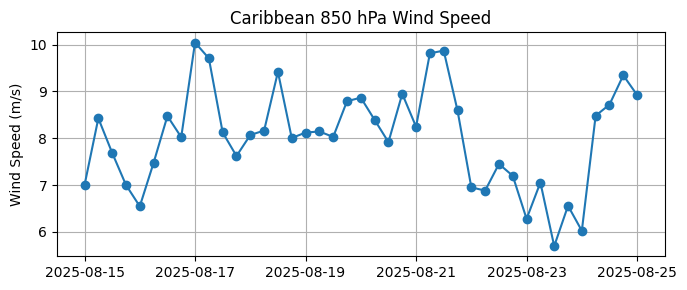

In [13]:
plt.figure(figsize=(7,3))
plt.plot(time_list, mean_speed_list, marker="o")

plt.title("Caribbean 850 hPa Wind Speed", fontsize=12)
plt.ylabel("Wind Speed (m/s)")

plt.grid(True)
plt.xticks()

plt.tight_layout()
plt.savefig("caribbean_850hPa_wind_speed.png", dpi=300, bbox_inches="tight")
plt.show()